<a href="https://colab.research.google.com/github/dhruvphansalkar/6301Project/blob/main/Reduced_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
data_path = os.path.join(os.getcwd(), "drive", "My Drive", "cs6301-sp23", "project_data", "data", "MergeResult_3.tsv")

Mounted at /content/drive


In [ ]:
!pip install transformers datasets evaluate
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:

import os
from pathlib import Path

import numpy as np
import nltk
nltk.download("punkt")
import pandas as pd
from datasets import Dataset, load_metric
from datasets.load import load_dataset
from transformers import AutoTokenizer
import preprocessor as p
from transformers import TrainingArguments, Trainer

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def fetch_data_from_csv(path):
  df = pd.read_table(path)
  df = pd.DataFrame(df)
  #return Dataset.from_pandas(df)
  return df

In [ ]:
def convertDFtoDataSet(df):
  ds = Dataset.from_pandas(df)
  return ds

In [ ]:
data = fetch_data_from_csv(data_path)

In [ ]:
def reduceClasses(classVal):
  if classVal == 'other_useful_information' or classVal == 'caution_and_advice' or classVal == 'sympathy_and_emotional_support' or classVal == 'not_related_or_irrelevant':
    return 'not_related_or_irrelevant'
  elif classVal == 'injured_or_dead_people' or classVal == 'missing_trapped_or_found_people' or classVal == 'infrastructure_and_utilities_damage':
    return 'emergency_services_required'
  else:
    return 'donation_needs_or_offers_or_volunteering_services'
  

In [ ]:
data['label'] = data['label'].apply(lambda lab: reduceClasses(lab))

In [ ]:
def understandData(df):
  print('--------------------------------Shape of the data is--------------------------')
  print(data.shape)

  print('----------------------the data contains following fields----------------------')
  print(data.columns)

  print('---------------------------------Data Description-----------------------------')
  print(data.describe)

  print('---------------------------------label count----------------------------------')
  print(data['label'].value_counts())

In [ ]:
understandData(data)

--------------------------------Shape of the data is--------------------------
(17382, 3)
----------------------the data contains following fields----------------------
Index(['tweet_id', 'tweet_text', 'label'], dtype='object')
---------------------------------Data Description-----------------------------
<bound method NDFrame.describe of                    tweet_id  \
0      '383600460340666369'   
1      '383790723222364161'   
2      '384232048124518400'   
3      '384860484643475456'   
4      '383407962619772928'   
...                     ...   
17377  '592126024437125121'   
17378  '593819547372638208'   
17379  '592137869482799104'   
17380  '591936980096659456'   
17381  '592344448887029761'   

                                              tweet_text  \
0      RT @Faiz_Baluch: #BalochistanEarthQuake Pakist...   
1      #Earthquake 2013-09-28 02:39:43 (M5.0) EAST OF...   
2      #earthquake M2.2: Puerto Rico region http://t....   
3      #PAKISTAN: #NASA releases images of Pak

In [ ]:
id2label = {0: 'not_related_or_irrelevant', 1: 'emergency_services_required', 2: 'donation_needs_or_offers_or_volunteering_services'}
label2id = {'not_related_or_irrelevant': 0, 'emergency_services_required': 1, 'donation_needs_or_offers_or_volunteering_services': 2}

In [ ]:
def exploratoryAnalysis(df):
  
  plt.figure(figsize=(8,6))
  sns.set_style(style='darkgrid')
  ax = sns.countplot(x = 'label', data = df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.title('Class Distribution')
  plt.show()

  plt.figure(figsize=(6,8))
  sns.set_style("darkgrid")
  df['label'].value_counts().plot.pie(autopct='%0.2f%%')
  plt.title("Percentage Contribution")
  plt.xlabel("percent contribution")
  plt.ylabel("label")
  plt.show()

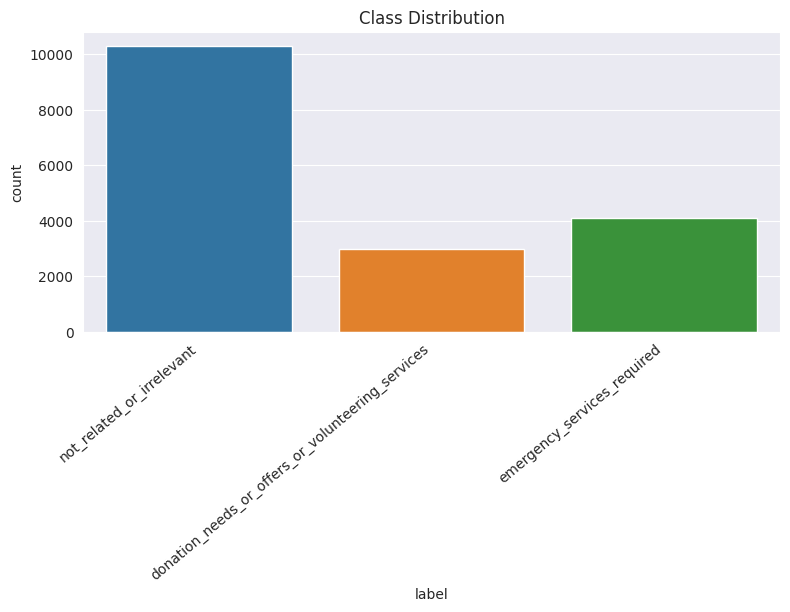

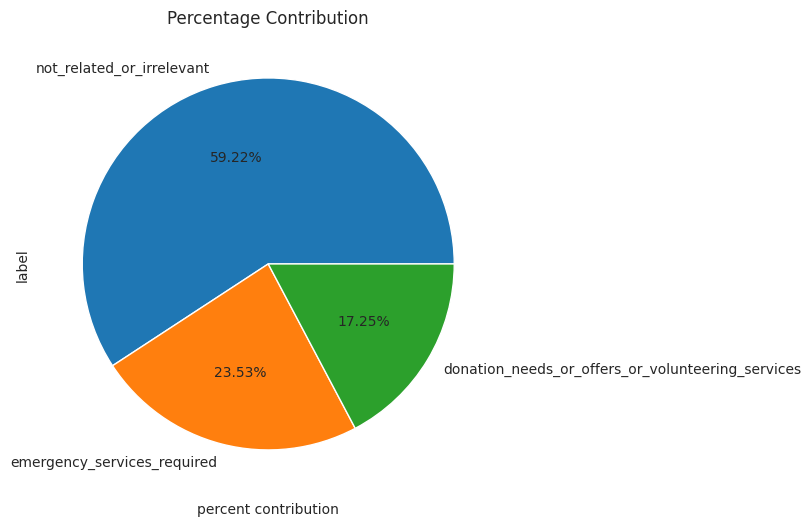

In [ ]:
exploratoryAnalysis(data)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def cleaner(text):

    cleaned = p.clean(text)
    cleaned=cleaned.replace("//"," ").replace("."," ")
    cleaned=re.sub(r'[^a-zA-Z]'," ",cleaned)
    cleaned=cleaned.strip() #removing whitespace
    cleaned=cleaned.lower() #converting into lower case words
    cleaned=re.sub(r'\w+\d+'," ",cleaned)#remove alphanumeric words
    cleaned=ps.stem(cleaned) #stemming 
    cleaned=[word for word in cleaned.split() if len(word)>2]
    cleaned=" ".join(cleaned)
    return cleaned

In [ ]:
#cleaning data
data['tweet_text'] = data['tweet_text'].apply(lambda text:cleaner(text))

In [ ]:
#converting label to id
def labeltoId(label):
  return label2id[label]

data['label'] = data['label'].apply(lambda label: labeltoId(label))

In [ ]:
dataset_data = convertDFtoDataSet(data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_data(dataset_data):
    return tokenizer(dataset_data["tweet_text"], padding='max_length')

In [ ]:
tokenized_data = dataset_data.map(tokenize_data, batched = True)

Map:   0%|          | 0/17382 [00:00<?, ? examples/s]

In [ ]:
tokenized_data = tokenized_data.train_test_split(test_size=0.1)
train_d = tokenized_data['train'].shuffle(seed=10)
eval_d = tokenized_data['test'].shuffle(seed=10)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-22-c203b637589b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [43]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
training_args = TrainingArguments(
    "test_trainer", 
    num_train_epochs=1,
    learning_rate=5e-2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01
    )
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_d, 
    eval_dataset=eval_d
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,5.073100


In [25]:
trainer.evaluate()

{'eval_loss': 0.3507750332355499,
 'eval_runtime': 61.2164,
 'eval_samples_per_second': 28.407,
 'eval_steps_per_second': 1.781,
 'epoch': 1.0}

In [ ]:
# Get predictions on the test dataset
test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_labels = eval_d["label"]
# Compute predicted class indices
print(test_logits)
predicted_class_indices = np.argmax(test_logits, axis=-1)
print(predicted_class_indices)

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, predicted_class_indices)

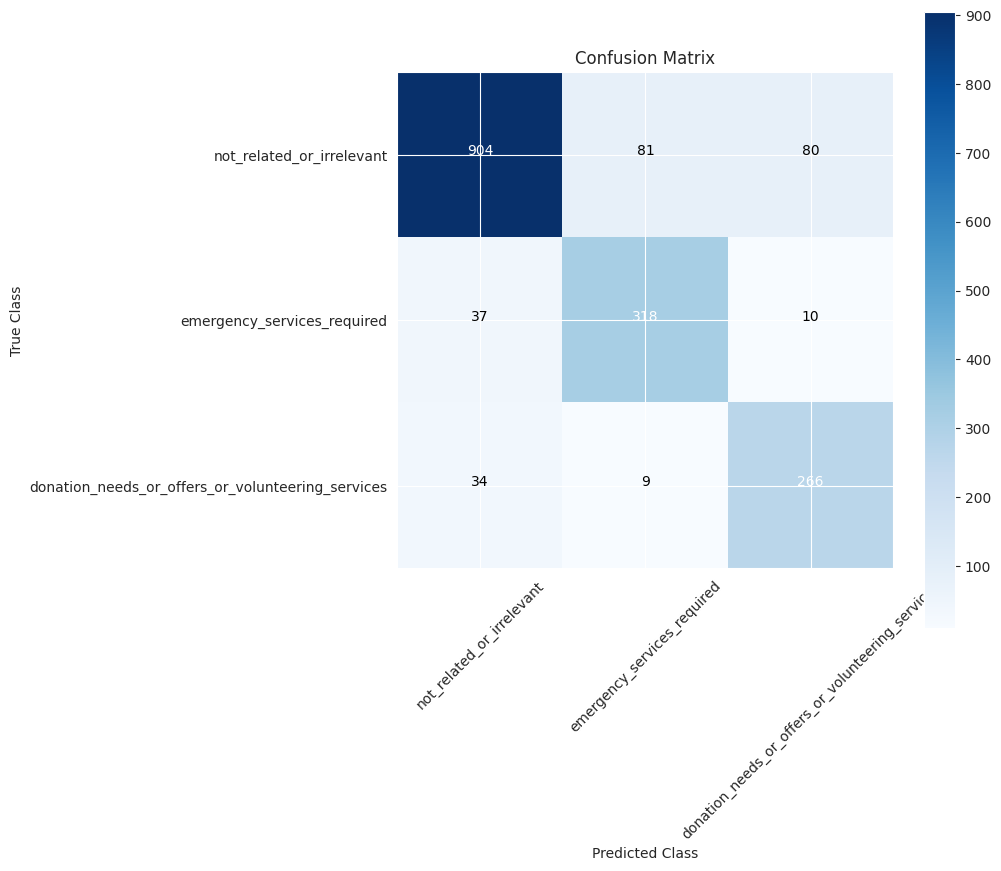

In [35]:
# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']


plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [36]:
precision, recall, f1, support = precision_recall_fscore_support(test_labels, predicted_class_indices)

# Print the results
for i in range(len(class_names)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

Class 0:
Precision: 0.9271794871794872
Recall: 0.8488262910798122
F1 Score: 0.8862745098039216
Class 1:
Precision: 0.7794117647058824
Recall: 0.8712328767123287
F1 Score: 0.8227684346701164
Class 2:
Precision: 0.7471910112359551
Recall: 0.86084142394822
F1 Score: 0.8


In [37]:
correct_predictions = np.sum(np.diag(confusion_mat))
total_predictions = np.sum(confusion_mat)
accuracy = correct_predictions / total_predictions
print(accuracy)

0.855664174813111


In [ ]:
# this is code for threshold basde predictions

[[ 2.5903928  -0.9773708  -0.6528616 ]
 [ 4.1750736  -1.2125466  -1.8611355 ]
 [-2.0986528   2.4679227  -1.2689561 ]
 ...
 [ 2.8134544  -1.8464948  -0.24220987]
 [ 2.7164638  -1.3218173  -0.37426215]
 [ 1.0056388   1.567125   -1.5094581 ]]
---------------------------------------------------------
[[13.335009    0.37629917  0.520554  ]
 [65.04463     0.29743886  0.15549596]
 [ 0.12262151 11.797913    0.28112495]
 ...
 [16.667395    0.15778929  0.7848914 ]
 [15.126736    0.2666503   0.6877966 ]
 [ 2.7336533   4.7928486   0.22102974]]
---------------------------------------------------------
[2 0 1 ... 2 2 1]


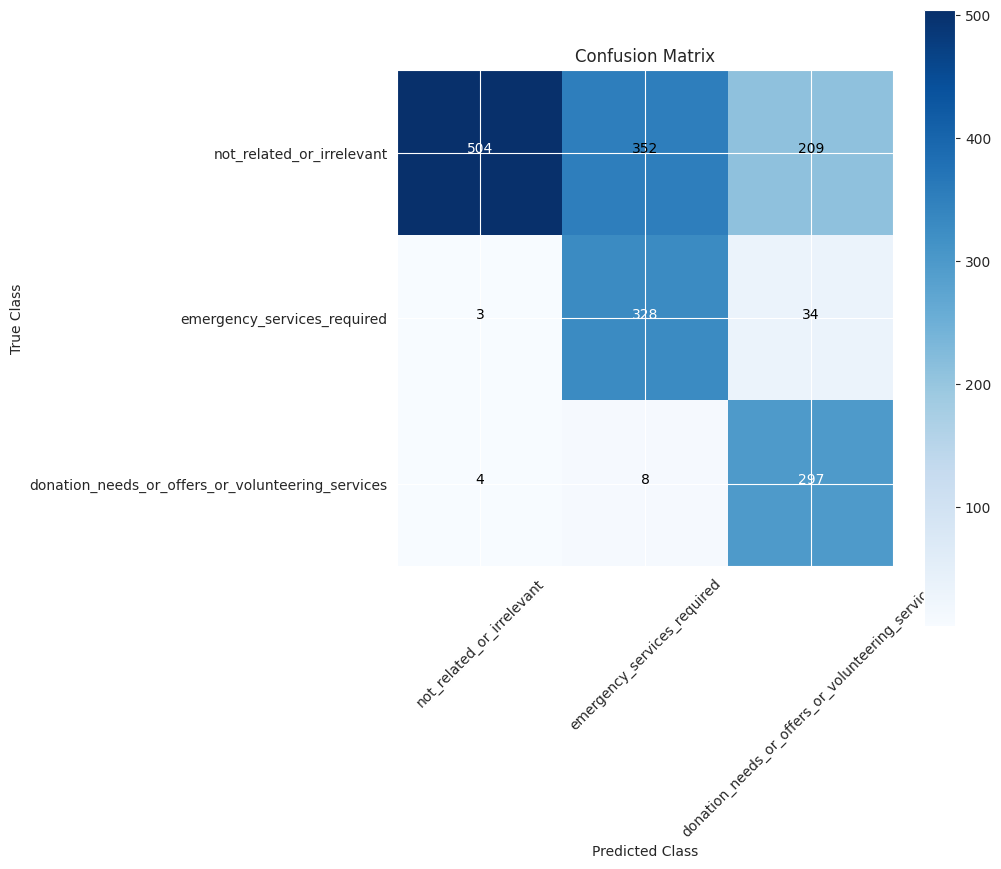

In [42]:
# Get predictions on the test dataset
# test_predictions = trainer.predict(eval_d)
# test_logits = test_predictions.predictions
# test_labels = eval_d["label"]
# predicted_class_indices = np.argmax(test_logits, axis=-1)


from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define thresholds for each class
thresholds = [0.5, 0.5, 0.5]

# Get predictions on the test dataset
#test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_probs = np.exp(test_logits) # convert logits to probabilities

print(test_logits)
print('---------------------------------------------------------')
print(test_probs)
print('---------------------------------------------------------')
# Apply thresholds to predictions
test_preds_thresh = np.zeros_like(predicted_class_indices)
for i in range(test_probs.shape[0]):
    for j in range(test_probs.shape[1]):
        if test_probs[i,j] >= thresholds[j]:
            test_preds_thresh[i] = j
print(test_preds_thresh)
# test_preds_thresh = np.argmax(test_preds_thresh, axis=-1)
# print(test_preds_thresh)
#test_labels = test_predictions.label_ids

# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, test_preds_thresh)

# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']
plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


In [39]:
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds_thresh)

# Print the results
for i in range(len(class_names)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

Class 0:
Precision: 0.9877622377622378
Recall: 0.5305164319248826
F1 Score: 0.6902871105681124
Class 1:
Precision: 0.5231259968102073
Recall: 0.8986301369863013
F1 Score: 0.6612903225806451
Class 2:
Precision: 0.55
Recall: 0.9611650485436893
F1 Score: 0.6996466431095407
